
=== METRICS (MA Strategy) ===
Total Return (Strategy): 14.904579659744515
Total Return (Buy & Hold): 57.31469758614864
Sharpe (Strategy): 1.2058737104648878
Sharpe (Buy & Hold): 1.3863478481770115
Max Drawdown (Strategy): -0.4560683817658462
Max Drawdown (Buy & Hold): -0.6633507922960666
Days: 1763

=== METRICS (Random Baseline) ===
Total Return (Strategy): 5.599575016998537
Total Return (Buy & Hold): 57.31469758614864
Sharpe (Strategy): 0.9412358553540698
Sharpe (Buy & Hold): 1.3863478481770115
Max Drawdown (Strategy): -0.40396847226779686
Max Drawdown (Buy & Hold): -0.6633507922960666
Days: 1763


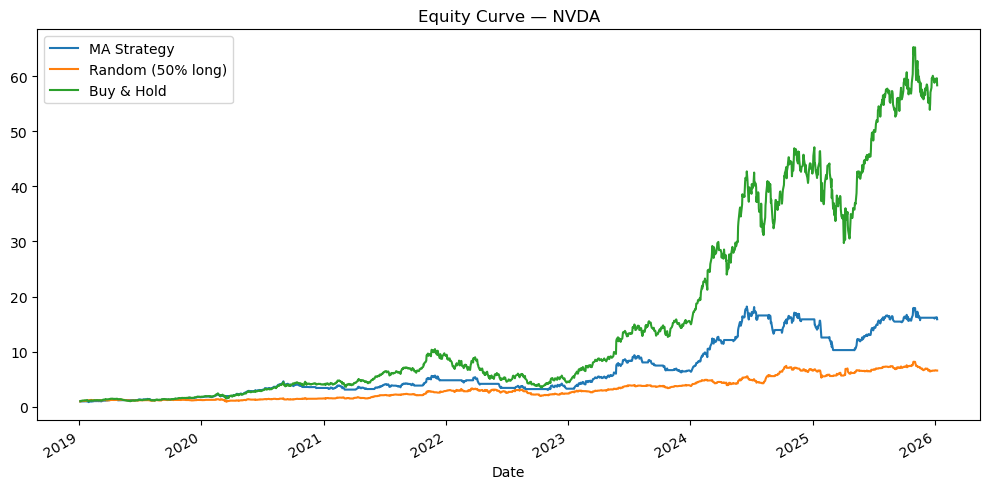


=== TOP 5 MA PARAMS BY SHARPE ===
 fast  slow  total_return   sharpe    max_dd
   10   100     25.375897 1.335233 -0.451700
   20   150     28.042871 1.324685 -0.472382
   15   100     20.756075 1.261540 -0.414408
    5   150     19.632946 1.226450 -0.530264
   10    30     14.904580 1.205874 -0.456068

=== SHARPE GRID (fast x slow) ===
slow    30     50     100    150
fast                            
5     1.140  1.014  1.072  1.226
10    1.206  1.053  1.335  1.175
15    1.080  1.093  1.262  1.189
20    0.994  1.068  1.147  1.325


In [12]:
"""
Walk-Forward Backtesting Engine (Quant + Software Dev)
- Pulls daily price data (yfinance)
- Builds a simple signal (moving-average crossover)
- Runs walk-forward evaluation (no shuffling)
- Backtests: long next day when signal=1, else cash
- Adds baselines (random) + buy & hold
- Adds parameter sweep across MA windows
- Reports metrics + plots equity curve comparisons
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf


# ===========================
# Metrics
# ===========================

@dataclass
class BacktestResult:
    equity: pd.Series
    returns: pd.Series
    buyhold_equity: pd.Series
    metrics: dict


def sharpe_ratio(daily_returns: pd.Series) -> float:
    r = daily_returns.dropna()
    if len(r) < 2 or r.std() == 0:
        return float("nan")
    return float(np.sqrt(252) * r.mean() / r.std())


def max_drawdown(equity: pd.Series) -> float:
    eq = equity.dropna()
    if eq.empty:
        return float("nan")
    peak = eq.cummax()
    drawdown = eq / peak - 1.0
    return float(drawdown.min())


# ===========================
# Data
# ===========================

def fetch_prices(ticker: str, start: str = "2018-01-01", end: Optional[str] = None) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, progress=False)
    if df.empty:
        raise ValueError(f"No data downloaded for {ticker}")

    close = df["Close"]
    # Sometimes yfinance/pandas gives 1-col DataFrame; force Series
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    close = close.squeeze()

    out = pd.DataFrame({"Close": close})
    out["ret"] = out["Close"].pct_change()
    return out.dropna()


# ===========================
# Signals
# ===========================

def moving_average_crossover_signal(df: pd.DataFrame, fast: int = 10, slow: int = 30) -> pd.Series:
    """
    Signal = 1 when fast MA > slow MA, else 0.
    Uses only information available up to time t (rolling).
    """
    close = df["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    close = close.squeeze()

    ma_fast = close.rolling(fast).mean()
    ma_slow = close.rolling(slow).mean()

    signal = (ma_fast > ma_slow).astype(int).squeeze()
    signal.name = "signal"
    return signal


def random_signal(index: pd.Index, p_long: float = 0.5, seed: int = 42) -> pd.Series:
    """
    Random baseline: long with probability p_long each day.
    """
    rng = np.random.default_rng(seed)
    sig = rng.binomial(1, p_long, size=len(index))
    return pd.Series(sig, index=index, name="signal")


# ===========================
# Backtest
# ===========================

def backtest_long_cash(df: pd.DataFrame, signal: pd.Series, initial_capital: float = 1.0) -> BacktestResult:
    """
    Rule:
      - If signal[t] == 1, take position for next day return ret[t]
      - Implemented by shifting signal by 1 day => yesterday's signal controls today's position
    """
    data = df.join(signal, how="inner")

    # Position for day t based on signal at day t-1 (prevents lookahead)
    data["position"] = data["signal"].shift(1).fillna(0)

    # Strategy returns
    data["strategy_ret"] = data["position"] * data["ret"]

    # Equity curves
    data["equity"] = initial_capital * (1 + data["strategy_ret"]).cumprod()
    data["buyhold_equity"] = initial_capital * (1 + data["ret"]).cumprod()

    metrics = {
        "Total Return (Strategy)": float(data["equity"].iloc[-1] - 1),
        "Total Return (Buy & Hold)": float(data["buyhold_equity"].iloc[-1] - 1),
        "Sharpe (Strategy)": sharpe_ratio(data["strategy_ret"]),
        "Sharpe (Buy & Hold)": sharpe_ratio(data["ret"]),
        "Max Drawdown (Strategy)": max_drawdown(data["equity"]),
        "Max Drawdown (Buy & Hold)": max_drawdown(data["buyhold_equity"]),
        "Days": int(len(data)),
    }

    return BacktestResult(
        equity=data["equity"],
        returns=data["strategy_ret"],
        buyhold_equity=data["buyhold_equity"],
        metrics=metrics,
    )


# ===========================
# Walk-forward wrapper
# ===========================

def walk_forward_backtest(df: pd.DataFrame, fast: int = 10, slow: int = 30, warmup: int = 252) -> BacktestResult:
    """
    For MA crossover there is no 'training', but we:
    - compute rolling MAs using past data only
    - start evaluation after a warmup period for stable indicators
    """
    if len(df) <= warmup + slow:
        raise ValueError("Not enough data for warmup/MA windows.")

    sig_full = moving_average_crossover_signal(df, fast=fast, slow=slow)

    df_eval = df.iloc[warmup:]
    sig_eval = sig_full.iloc[warmup:]

    return backtest_long_cash(df_eval, sig_eval)


# ===========================
# Parameter sweep
# ===========================

def sweep_ma_params(df: pd.DataFrame, warmup: int = 252) -> pd.DataFrame:
    rows = []
    df_eval = df.iloc[warmup:]

    for fast in [5, 10, 15, 20]:
        for slow in [30, 50, 100, 150]:
            if fast >= slow:
                continue
            sig = moving_average_crossover_signal(df, fast=fast, slow=slow).iloc[warmup:]
            res = backtest_long_cash(df_eval, sig)
            rows.append({
                "fast": fast,
                "slow": slow,
                "total_return": res.metrics["Total Return (Strategy)"],
                "sharpe": res.metrics["Sharpe (Strategy)"],
                "max_dd": res.metrics["Max Drawdown (Strategy)"],
            })

    return pd.DataFrame(rows).sort_values("sharpe", ascending=False)


# ===========================
# Run demo
# ===========================

def print_metrics(title: str, metrics: dict):
    print(f"\n=== {title} ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")


def main():
    ticker = "NVDA"
    start = "2018-01-01"
    warmup = 252

    df = fetch_prices(ticker, start=start)

    # Main MA strategy
    res_ma = walk_forward_backtest(df, fast=10, slow=30, warmup=warmup)

    # Random baseline (same evaluation window)
    df_eval = df.iloc[warmup:]
    sig_rand = random_signal(df_eval.index, p_long=0.5, seed=42)
    res_rand = backtest_long_cash(df_eval, sig_rand)

    # Print metrics
    print_metrics("METRICS (MA Strategy)", res_ma.metrics)
    print_metrics("METRICS (Random Baseline)", res_rand.metrics)

    # Plot equity curves
    plt.figure(figsize=(10, 5))
    res_ma.equity.plot(label="MA Strategy")
    res_rand.equity.plot(label="Random (50% long)")
    res_ma.buyhold_equity.plot(label="Buy & Hold")
    plt.title(f"Equity Curve — {ticker}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Parameter sweep
    sweep = sweep_ma_params(df, warmup=warmup)
    print("\n=== TOP 5 MA PARAMS BY SHARPE ===")
    print(sweep.head(5).to_string(index=False))

    # Optional: Sharpe grid
    pivot = sweep.pivot(index="fast", columns="slow", values="sharpe")
    print("\n=== SHARPE GRID (fast x slow) ===")
    print(pivot.round(3).to_string())


main()

